In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l
#@save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [3]:
DATA_HUB['kaggle_house_train'] = ( #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = ( #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [4]:
train_data = pd.read_csv(d2l.download('kaggle_house_train'))
test_data = pd.read_csv(d2l.download('kaggle_house_test'))

In [5]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


### 观察前四列和后三个特征

In [6]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


### kaggle都有一个id栏，这个是不能参与训练的，无意义,所以将他去掉
### 注意在切片中[a:b]是取a到b-1
### 因为比赛已经有测试集了，所以这里就把训练集和测试集concat一起了

In [7]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
all_features.shape

(2919, 79)

### pands里面的object等于py里面的str

### 第一个命令表示读取是数值的列名，从而先对数值进行标准化处理
### 第二行注意这个apply命令，这个是对每一列的数值进行操作，lambda函数之前讲过

In [8]:
# 若⽆法获得测试数据，则可根据训练数据计算均值和标准差
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 在标准化数据之后，所有均值消失，因此我们可以将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [9]:
all_features['LotFrontage']

0      -0.184443
1       0.458096
2      -0.055935
3      -0.398622
4       0.629439
          ...   
1454   -2.069222
1455   -2.069222
1456    3.884968
1457   -0.312950
1458    0.201080
Name: LotFrontage, Length: 2919, dtype: float64

### 接下来处理字符串列
### get_dummies处理之后，原来的列就没有了(如MSZoning)，取而代之的是原列名_features(MSZoning_RL...)！

In [10]:
# “Dummy_na=True”将“na”（缺失值）视为有效的特征值，并为其创建指⽰符特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape, all_features['MSZoning_RL']

((2919, 331),
 0       1
 1       1
 2       1
 3       1
 4       1
        ..
 1454    0
 1455    0
 1456    1
 1457    1
 1458    1
 Name: MSZoning_RL, Length: 2919, dtype: uint8)

### 使用values，将pandas格式中提取NumPy格式，并转化为张量用于训练
### train_labels是提取的train_data(1460，81)，里面选取SalePrice列的数据进行转换

In [11]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(
    train_data['SalePrice'].values.reshape(-1, 1), dtype=torch.float32)
# demo = torch.tensor(train_data['PoolArea'].values, dtype=torch.float32)
train_features.shape, train_labels.shape, test_features.shape

(torch.Size([1460, 331]), torch.Size([1460, 1]), torch.Size([1459, 331]))

### 看一下得到了什么
### 得到了train_features(1460,331)用于训练;train_labels(1460,1)训练数据对应的房价;test_features(1459,331)用于预测

## 训练

In [12]:
loss = nn.MSELoss()
in_features = train_features.shape[1]
def get_net():
    net = nn.Sequential(nn.Linear(in_features,1))
    return net
in_features

331

### 损失
### 对于房价来讲，应该使用相对误差。在此采取取对数再相减的方法
### 可以分别用[400,390][12,10]两组数来验证合理性
### 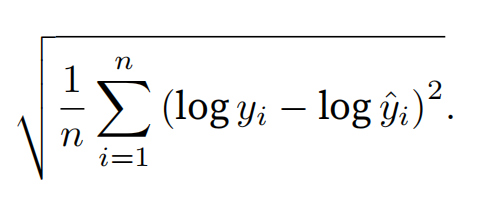

In [13]:
def log_rmse(net, features, labels):
    # 为了在取对数时进⼀步稳定该值，将⼩于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                            torch.log(labels)))
    return rmse.item()

In [14]:
def train(net, train_features, train_labels, test_features, test_labels,
            num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这⾥使⽤的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                lr = learning_rate,
                                weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

### K折交叉验证

### 分成K个不同的子集，然后执行K次模型训练和验证，每次再K-1个子集上进行训练，并再剩余的一个子集进行验证，最后通过对K次实验的结果取平均来估计训练和验证误差

### 这里面X，y对应的是train里面的train_features, train_labels值
### 第五行开始，首先分片，没一片是总数/k个个数。得到fold_size=292
### 先把训练数据清零
### slice是切片的工具，具体见下文，默认的步长为一。这一步得到part为各自切片后的X,y数据
### i是下面的循环，这个函数写在i循环下面，当j=i时，指定此为验证集，part切片得到的数据赋给valid。当j!=i时，此时k=5时其余的四个应该都是这一条，则赋到train数据中。当第一次j!=i时，即第一个elif条件，赋值即可。但当后三次时，应该进行cat拼接起来，这里的0表示按维度0拼接（行）
### 最后得到训练集和验证集，分别为4/5的训练，1/5的验证

In [27]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

### 第一个参数默认行进行切片，切从第二个到第5-1=4个

In [28]:
x1 = torch.randn(6, 7)
x2 = slice(2, 5)
x1, x2, x1[x2, :].shape, x1[x2, :], x1[x2, x2]

(tensor([[-0.8395,  0.0889, -0.1568, -0.5556,  0.5240,  1.1080,  1.7148],
         [-2.9232, -0.0060, -2.1514, -1.1870,  0.8534, -1.6519,  1.6586],
         [-1.0398,  0.0369, -1.2592,  0.4807,  0.4048, -0.2949, -0.2115],
         [ 0.8220, -0.7045, -0.9553,  0.4993, -0.1584, -0.7187, -1.0840],
         [-0.2027, -0.0117,  0.3927,  0.6283, -0.0121, -2.4030, -0.4888],
         [ 0.7346,  0.7490,  0.9968, -0.2208, -0.4263, -1.1519,  1.0763]]),
 slice(2, 5, None),
 torch.Size([3, 7]),
 tensor([[-1.0398,  0.0369, -1.2592,  0.4807,  0.4048, -0.2949, -0.2115],
         [ 0.8220, -0.7045, -0.9553,  0.4993, -0.1584, -0.7187, -1.0840],
         [-0.2027, -0.0117,  0.3927,  0.6283, -0.0121, -2.4030, -0.4888]]),
 tensor([[-1.2592,  0.4807,  0.4048],
         [-0.9553,  0.4993, -0.1584],
         [ 0.3927,  0.6283, -0.0121]]))

In [29]:
def XX(n):
    assert n > 1
    return n
XX(2)

2

### 这里面的train_ls[-1]为直接取最后一个epoch训练的ls

In [31]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
            batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                    weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                    xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                    legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
            f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

折1，训练log rmse0.170154, 验证log rmse0.157170
折2，训练log rmse0.162129, 验证log rmse0.189500
折3，训练log rmse0.164259, 验证log rmse0.168856
折4，训练log rmse0.167857, 验证log rmse0.154783
折5，训练log rmse0.163433, 验证log rmse0.183017
5-折验证: 平均训练log rmse: 0.165566, 平均验证log rmse: 0.170665


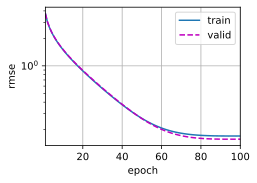

In [32]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                            weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
    f'平均验证log rmse: {float(valid_l):f}')

### 当经过上面的调参后，确认该选择的最有超参数后，则可用全部的数据对其训练

In [33]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                    num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
        ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将⽹络应⽤于测试集。
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

训练log rmse：0.162459


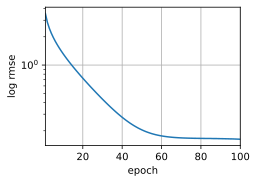

In [34]:
train_and_pred(train_features, test_features, train_labels, test_data,
    num_epochs, lr, weight_decay, batch_size)